# Detectron2 on FRSign dataset

**NOTE:** This is an adaptation of the example [Detectron2 on SKU-110K dataset](https://github.com/aws-samples/amazon-sagemaker-pytorch-detectron2), now applied to the use case of traffic lights detection in railways.

## Background

Detectron2 is a Computer Vision framework which implements Object Detection algorithms. It is developed by Facebook AI Research team. While its ancestor, Detectron, was completely written in Caffe, Detecton2 was refactored in PyTorch to enable fast experiments and iterations from. Detectron2 has a rich model zoo that contains State-of-the-Art models for object detection, semantic segmentation and pose estimation, to cite a few. A modular design makes Detectron2 easily extensible, and, hence, cutting-edge research projects can be implemented on top of it. 

We use Detectron2 to train and evaluate models on the [FRSign dataset](https://frsign.irt-systemx.fr/). This open source dataset contains a large-scale and accurate set of images for vision-based railway traffic light detection and recognition. It contains more than 100,000 images illustrating six types of French railway traffic lights and their possible color combinations, together with the relevant information regarding their acquisition such as date, time, sensor parameters, and bounding boxes.

In this noteboook we use Object Detection models from Detectron2's model zoo. We then leverage Amazon SageMaker ML platform to finetune pre-trained models on FRSign dataset and deploy trained model for inference.

## 1. Setup

#### Precondition
If you are executing this notebook using Sagemaker Notebook instance or Sagemaker Studio instance, please make sure the IAM role used has the `AmazonSageMakerFullAccess` policy.

We start by importing required Python libraries and configuring some common parameters:

In [1]:
import boto3
import sagemaker

assert (
    sagemaker.__version__.split(".")[0] == "2"
), "Please upgrade SageMaker Python SDK to version 2"

In [2]:
bucket = "rodzanto2021ml"  # TODO: update this value with your bucket name
prefix_data = "train/frsign/data"
prefix_model = "train/frsign/training_artefacts"
prefix_code = "train/frsign/model"
prefix_predictions = "train/frsign/predictions"
#local_folder = "cache"   # cache folder used to store downloaded data - not versioned

sm_session = sagemaker.Session(default_bucket=bucket)
role = sagemaker.get_execution_role()
region = sm_session.boto_region_name
account = sm_session.account_id()

## 2. Dataset Preparation


**IMPORTANT:**

To prepare the FRSign dataset follow the instructions in the separated notebook "frsign_doc".

That notebook will take a sample of the FRSign dataset, and prepare the manifest files required by our Detectron2 example for using with SageMaker.

## 3. Building the Training Container


Before we can build training container, we need to authethicate in shared ECR repo to retrieve Pytorch base image and in private ECR repository. Enter your region and account id below, and then execute the following cell to do it.

In [1]:
%%bash

REGION='eu-west-1'
ACCOUNT='889960878219'

aws ecr get-login-password --region $REGION | docker login --username AWS --password-stdin 763104351884.dkr.ecr.$REGION.amazonaws.com
# loging to your private ECR
aws ecr get-login-password --region $REGION | docker login --username AWS --password-stdin $ACCOUNT.dkr.ecr.$REGION.amazonaws.com

Login Succeeded
Login Succeeded


WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store



Our build container uses AWS-authored Pytorch container as a base image. We extend base image with Detecton2 dependencies and copy training script. Execute cell below to review Dockerfile content.

In [2]:
%%bash

# execute this cell to review Docker container
pygmentize -l docker Dockerfile.sku110ktraining

# Build an image of Detectron2 that can do distributing training on Amazon Sagemaker

# using Sagemaker PyTorch container as base image
# from https://github.com/aws/sagemaker-pytorch-container

ARG REGION
FROM 763104351884.dkr.ecr.$REGION.amazonaws.com/pytorch-training:1.6.0-gpu-py36-cu101-ubuntu16.04
LABEL author="pirrera@amazon.com"

############# Detectron2 pre-built binaries Pytorch default install ############
RUN pip install --upgrade torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

############# Detectron2 section ##############
RUN pip install \
   --no-cache-dir pycocotools~=2.0.0 \
   --no-cache-dir https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/detectron2-0.4%2Bcu101-cp36-cp36m-linux_x86_64.whl

ENV FORCE_CUDA="1"
# Build D2 only for Volta architecture - V100 chips (ml.p3 AWS instances)
ENV TORCH_CUDA_ARCH_LIST="Volta"

# Set a fixed model cache directory. Detectron2 requirement
ENV FVCORE_CACHE="/tmp"

####

Next, we build the Docker container locally and then push it to ECR repository, so SageMaker can deploy this container on compute nodes at training time. Run command bellow to build and push container. The size of the resulting Docker image is approximately 5GB.

In [4]:
#%%bash
!./build_and_push.sh sagemaker-d2-train-sku110k latest Dockerfile.sku110ktraining

Working in region eu-west-1
WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded
Sending build context to Docker daemon  25.23GB
Step 1/14 : ARG REGION
Step 2/14 : FROM 763104351884.dkr.ecr.$REGION.amazonaws.com/pytorch-training:1.6.0-gpu-py36-cu101-ubuntu16.04
 ---> 30e42e4701a4
Step 3/14 : LABEL author="pirrera@amazon.com"
 ---> Using cache
 ---> 9306a2d3ce5d
Step 4/14 : RUN pip install --upgrade torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
 ---> Using cache
 ---> f95e7a891485
Step 5/14 : RUN pip install    --no-cache-dir pycocotools~=2.0.0    --no-cache-dir https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/detectron2-0.4%2Bcu101-cp36-cp36m-linux_x86_64.whl
 --

## 4. Training using Amazon SageMaker 

To run training job on SageMaker we will:
* Rely on the existing training container from Amazon Elastic Container Registry ("ECR"), this container includes all runtime dependencies and training script;
* define training job configuration which includes training cluster configuration and model hyperparameters;
* schedule training job, observe its progress.

### Configure SageMaker training job

Configuration includes following components:
* data configuration defines where train/test/val datasets are stored;
* container configuration;
* model hyperparameters;
* training job parameters such as size of cluster and instance type, metrics to monitor, etc.

In [4]:
import json
import os
import tarfile
import tempfile
from datetime import datetime
from pathlib import Path
from typing import Mapping, Optional, Sequence
from urllib import request

import boto3
import numpy as np
import pandas as pd
from tqdm import tqdm

from sagemaker.estimator import Estimator

In [5]:
# Data configuration

training_channel = f"s3://{bucket}/{prefix_data}/training/"
validation_channel = f"s3://{bucket}/{prefix_data}/validation/"
test_channel = f"s3://{bucket}/{prefix_data}/test/"

annotation_channel = f"s3://{bucket}/{prefix_data}/annotations/"

# NOTE: We are using a subset of the classes available in the FRSign dataset. Adapt this if required depending on
# the classes in your dataset.
classes = [
    "Chassis A (3 feux verticaux)",
    "Chassis C (5 feux verticaux)",
    "Chassis F (6 & 1 feux en L inverse)",
    "Chassis H (6 & 3 feux en S)",
    "Chassis ID2 (2 feux horizontaux)",
    "Chassis ID3 (3 feux horizontaux)",
    "Chassis R (6 feux dans un disque)",
]

In [6]:
# Container configuration

container_name = "sagemaker-d2-train-sku110k" #This is the name of the container pushed in the separed notebook
container_version = "latest"
training_image_uri = (
    f"{account}.dkr.ecr.{region}.amazonaws.com/{container_name}:{container_version}"
)

In [7]:
# Metrics to monitor during training, each metric is scraped from container Stdout

metrics = [
    {"Name": "training:loss", "Regex": "total_loss: ([0-9\\.]+)",},
    {"Name": "training:loss_cls", "Regex": "loss_cls: ([0-9\\.]+)",},
    {"Name": "training:loss_box_reg", "Regex": "loss_box_reg: ([0-9\\.]+)",},
    {"Name": "training:loss_rpn_cls", "Regex": "loss_rpn_cls: ([0-9\\.]+)",},
    {"Name": "training:loss_rpn_loc", "Regex": "loss_rpn_loc: ([0-9\\.]+)",},
    {"Name": "validation:loss", "Regex": "total_val_loss: ([0-9\\.]+)",},
    {"Name": "validation:loss_cls", "Regex": "val_loss_cls: ([0-9\\.]+)",},
    {"Name": "validation:loss_box_reg", "Regex": "val_loss_box_reg: ([0-9\\.]+)",},
    {"Name": "validation:loss_rpn_cls", "Regex": "val_loss_rpn_cls: ([0-9\\.]+)",},
    {"Name": "validation:loss_rpn_loc", "Regex": "val_loss_rpn_loc: ([0-9\\.]+)",},
]

In [8]:
# Training instance type

training_instance = "ml.g4dn.12xlarge"
if training_instance.startswith("local"):
    training_session = sagemaker.LocalSession()
    training_session.config = {"local": {"local_code": True}}
else:
    training_session = sm_session

The following hyper-parameters are used in the training job. Feel free to change them and experiment.

In [9]:
# Model Hyperparameters

od_algorithm = "faster_rcnn"  # choose one in ("faster_rcnn", "retinanet")
training_job_hp = {
    # Dataset
    "classes": json.dumps(classes),
    "dataset-name": json.dumps("sku110k"),
    "label-name": json.dumps("sku"),
    # Algo specs
    "model-type": json.dumps(od_algorithm),
    "backbone": json.dumps("R_101_FPN"),
    # Data loader
    "num-iter": 900,
    "log-period": 500,
    "batch-size": 16,
    "num-workers": 8,
    # Optimization
    "lr": 0.005,
    "lr-schedule": 3,
    # Faster-RCNN specific
    "num-rpn": 517,
    "bbox-head-pos-fraction": 0.2,
    "bbox-rpn-pos-fraction": 0.4,
    # Prediction specific
    "nms-thr": 0.2,
    "pred-thr": 0.1,
    "det-per-img": 300,
    # Evaluation
    "evaluation-type": "fast",
}

In [12]:
# Define the Sagemaker Training job object and start training

d2_estimator = Estimator(
    image_uri=training_image_uri,
    role=role,
    sagemaker_session=training_session,
    instance_count=1,
    instance_type=training_instance,
    hyperparameters=training_job_hp,
    metric_definitions=metrics,
    output_path=f"s3://{bucket}/{prefix_model}",
    base_job_name=f"detectron2-{od_algorithm.replace('_', '-')}",
)

d2_estimator.fit(
    {
        "training": training_channel,
        "validation": validation_channel,
        "test": test_channel,
        "annotation": annotation_channel,
    },
    wait=False,
)

In [163]:
print(f's3://{bucket}/{prefix_model}/{d2_estimator.latest_training_job.name}/output/model.tar.gz')

s3://rodzanto2021ml/train/frsign/training_artefacts/detectron2-faster-rcnn-2021-10-29-15-11-19-423/output/model.tar.gz


## 5. HyperParameter Optimization with Amazon SageMaker (Optional)

SageMaker SDK comes with the `tuner` module that can be used to search for the optimal hyper-parameters (see more details [here](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning.html)). Let's run several experiment with different model hyperparameters with aim to minize the validation loss. 

`hparams_range` dictionary that defines the hyper-parameters to be optimized. Feel free to modify it. ⚠️ Please note, a tuning job runs multiple training job. Therefore, be aware of the amount of computational resources that a tuner job requires.

In [ ]:
from sagemaker.tuner import (
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
    IntegerParameter,
)

od_algorithm = "retinanet"  # choose one in ("faster_rcnn", "retinanet")

In [ ]:
hparams_range = {
    "lr": ContinuousParameter(0.0005, 0.1),
}
if od_algorithm == "faster_rcnn":
    hparams_range.update(
        {
            "bbox-rpn-pos-fraction": ContinuousParameter(0.1, 0.5),
            "bbox-head-pos-fraction": ContinuousParameter(0.1, 0.5),
        }
    )
elif od_algorithm == "retinanet":
    hparams_range.update(
        {
            "focal-loss-gamma": ContinuousParameter(2.5, 5.0),
            "focal-loss-alpha": ContinuousParameter(0.3, 1.0),
        }
    )
else:
    assert False, f"{od_algorithm} not supported"

In [ ]:
obj_metric_name = "validation:loss"
obj_type = "Minimize"
metric_definitions = [
    {"Name": "training:loss", "Regex": "total_loss: ([0-9\\.]+)",},
    {"Name": "training:loss_cls", "Regex": "loss_cls: ([0-9\\.]+)",},
    {"Name": "training:loss_box_reg", "Regex": "loss_box_reg: ([0-9\\.]+)",},
    {"Name": obj_metric_name, "Regex": "total_val_loss: ([0-9\\.]+)",},
    {"Name": "validation:loss_cls", "Regex": "val_loss_cls: ([0-9\\.]+)",},
    {"Name": "validation:loss_box_reg", "Regex": "val_loss_box_reg: ([0-9\\.]+)",},
]

In [ ]:
fixed_hparams = {
    # Dataset
    "classes": json.dumps(classes),
    "dataset-name": json.dumps("sku110k"),
    "label-name": json.dumps("sku"),
    # Algo specs
    "model-type": json.dumps(od_algorithm),
    "backbone": json.dumps("R_101_FPN"),
    # Data loader
    "num-iter": 9000,
    "log-period": 500,
    "batch-size": 16,
    "num-workers": 8,
    # Optimization
    "lr-schedule": 3,
    # Prediction specific
    "nms-thr": 0.2,
    "pred-thr": 0.1,
    "det-per-img": 300,
    # Evaluation
    "evaluation-type": "fast",
}

hpo_estimator = Estimator(
    image_uri=training_image_uri,
    role=role,
    sagemaker_session=sm_session,
    instance_count=1,
    instance_type="ml.g4dn.12xlarge",
    hyperparameters=fixed_hparams,
    output_path=f"s3://{bucket}/{prefix_model}",
    use_spot_instances=True,  # Use spot instances to spare a
    max_run=2 * 60 * 60,
    max_wait=3 * 60 * 60,
)

In [ ]:
tuner = HyperparameterTuner(
    hpo_estimator,
    obj_metric_name,
    hparams_range,
    metric_definitions,
    objective_type=obj_type,
    max_jobs=2,
    max_parallel_jobs=2,
    base_tuning_job_name=f"hpo-d2-{od_algorithm.replace('_', '-')}",
)

In [ ]:
tuner.fit(
    inputs={
        "training": training_channel,
        "validation": validation_channel,
        "test": test_channel,
        "annotation": annotation_channel,
    },
    wait=False,
)

In [ ]:
# Let's review outcomes of HyperParameter search

hpo_tuning_job_name = tuner.latest_tuning_job.name
bayes_metrics = sagemaker.HyperparameterTuningJobAnalytics(
    hpo_tuning_job_name
).dataframe()
bayes_metrics.sort_values(["FinalObjectiveValue"], ascending=True)

## 6. Model Deployment on Amazon SageMaker

Just like with model training, SageMaker is using containers to run inference.

We will run batch inference, i.e. running inference against large chunk of images. We use [SageMaker Batch Transform](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-batch.html) to do it. 

In [13]:
from sagemaker.pytorch import PyTorchModel

**NOTE: For the following sections (6.1a & 6.1b), run one or the other depending on your choice...**

#### 6.1a Deploy best model from HPO tuning job in step 5 above

If you decided to run the section -5- above then an HPO job was executed, we can then attach the tuning job and fetch the best model from it:

In [ ]:
from sagemaker.tuner import HyperparameterTuner

tuning_job_id = "Insert tuning job id"
attached_tuner = HyperparameterTuner.attach(tuning_job_id)

best_estimator = attached_tuner.best_estimator()

best_estimator.latest_training_job.describe()
training_job_artifact = best_estimator.latest_training_job.describe()["ModelArtifacts"][
    "S3ModelArtifacts"
]

#### 6.1b Deploy model trained in step 4 above

If you decided not to run the section -5- above, we can then just specify the S3 URI of the model artifact trained in our step -4- above:

In [164]:
training_job_artifact = f's3://{bucket}/{prefix_model}/{d2_estimator.latest_training_job.name}/output/model.tar.gz'
print(training_job_artifact)

s3://rodzanto2021ml/train/frsign/training_artefacts/detectron2-faster-rcnn-2021-10-29-15-11-19-423/output/model.tar.gz


### 6.2 Batch inference with SageMaker Transform job

In [15]:
# Define parameters of inference container

serve_container_name = "sagemaker-d2-serve"
serve_container_version = "latest"
serve_image_uri = f"{account}.dkr.ecr.{region}.amazonaws.com/{serve_container_name}:{serve_container_version}"

inference_output = f"s3://{bucket}/{prefix_predictions}/{serve_container_name}/{Path(test_channel).name}_channel/{training_job_artifact.split('/')[-3]}"
inference_output

's3://rodzanto2021ml/train/frsign/predictions/sagemaker-d2-serve/test_channel/detectron2-faster-rcnn-2021-10-29-15-11-19-423'

In [18]:
# Compile SageMaker model object and configure Batch Transform job

model = PyTorchModel(
    name="d2-frsign-model",
    model_data=training_job_artifact,
    role=role,
    sagemaker_session=sm_session,
    entry_point="predict_sku110k.py",
    source_dir="container_serving",
    image_uri=serve_image_uri,
    framework_version="1.6.0",
    code_location=f"s3://{bucket}/{prefix_code}",
)

transformer = model.transformer(
    instance_count=1,
    instance_type="ml.g4dn.2xlarge",  # "ml.p2.xlarge", #
    output_path=inference_output,
    max_payload=16,
)

In [19]:
# Start Batch Transform job

transformer.transform(
    data=test_channel,
    data_type="S3Prefix",
    content_type="application/x-image",
    wait=False,
)

### 6.2.1 Visualization

Once our batch inference job is completed, let's visualize predictions. We'll use single random image for visualization. Feel free to re-run it many times.

In [20]:
import io

import matplotlib
import matplotlib.patches as patches
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

In [27]:
def key_from_uri(s3_uri: str) -> str:
    """Get S3 object key from its URI"""
    return "/".join(Path(s3_uri).parts[2:])


bucket_rsr = boto3.resource("s3").Bucket(bucket)
predict_objs = list(
    bucket_rsr.objects.filter(Prefix=key_from_uri(inference_output) + "/")
)
img_objs = list(bucket_rsr.objects.filter(Prefix=key_from_uri(test_channel)))
#img_objs

In [155]:
COLORS = [
    (255, 0, 0),
    (255, 128, 0),
    (255, 255, 0),
    (128, 255, 0),
    (0, 255, 0),
    (0, 255, 128),
    (0, 255, 255)
]


def plot_predictions_on_image(
    p_img: np.ndarray, p_preds: Mapping, score_thr: float = 0.5, show=True
) -> plt.Figure:
    r"""Plot bounding boxes predicted by an inference job on the corresponding image

    Parameters
    ----------
    p_img : np.ndarray
        input image used for prediction
    p_preds : Mapping
        dictionary with bounding boxes, predicted classes and confidence scores
    score_thr : float, optional
        show bounding boxes whose confidence score is bigger than `score_thr`, by default 0.5
    show : bool, optional
        show figure if True do not otherwise, by default True

    Returns
    -------
    plt.Figure
        figure handler

    Raises
    ------
    IOError
        If the prediction dictionary `p_preds` does not contain one of the required keys:
        `pred_classes`, `pred_boxes` and `scores`
    """
    for required_key in ("pred_classes", "pred_boxes", "scores"):
        if required_key not in p_preds:
            raise IOError(f"Missing required key: {required_key}")

    fig, fig_axis = plt.subplots(1)
    fig_axis.imshow(p_img)
    for class_id, bbox, score in zip(
        p_preds["pred_classes"], p_preds["pred_boxes"], p_preds["scores"]
    ):
        if score < score_thr:
            break  # bounding boxes are sorted by confidence score in descending order
        rect = patches.Rectangle(
            (bbox[0], bbox[1]),
            bbox[2] - bbox[0],
            bbox[3] - bbox[1],
            linewidth=1,
            edgecolor=[COLORS[int(class_id)][0]/255, COLORS[int(class_id)][1]/255, COLORS[int(class_id)][2]/255],
            #edgecolor=[0,200/255,0],
            facecolor="none",
            label=classes[int(class_id)]
        )
        fig_axis.add_patch(rect)
    plt.axis("off")
    plt.legend(prop={'size': 6})
    if show:
        plt.show()
    return fig

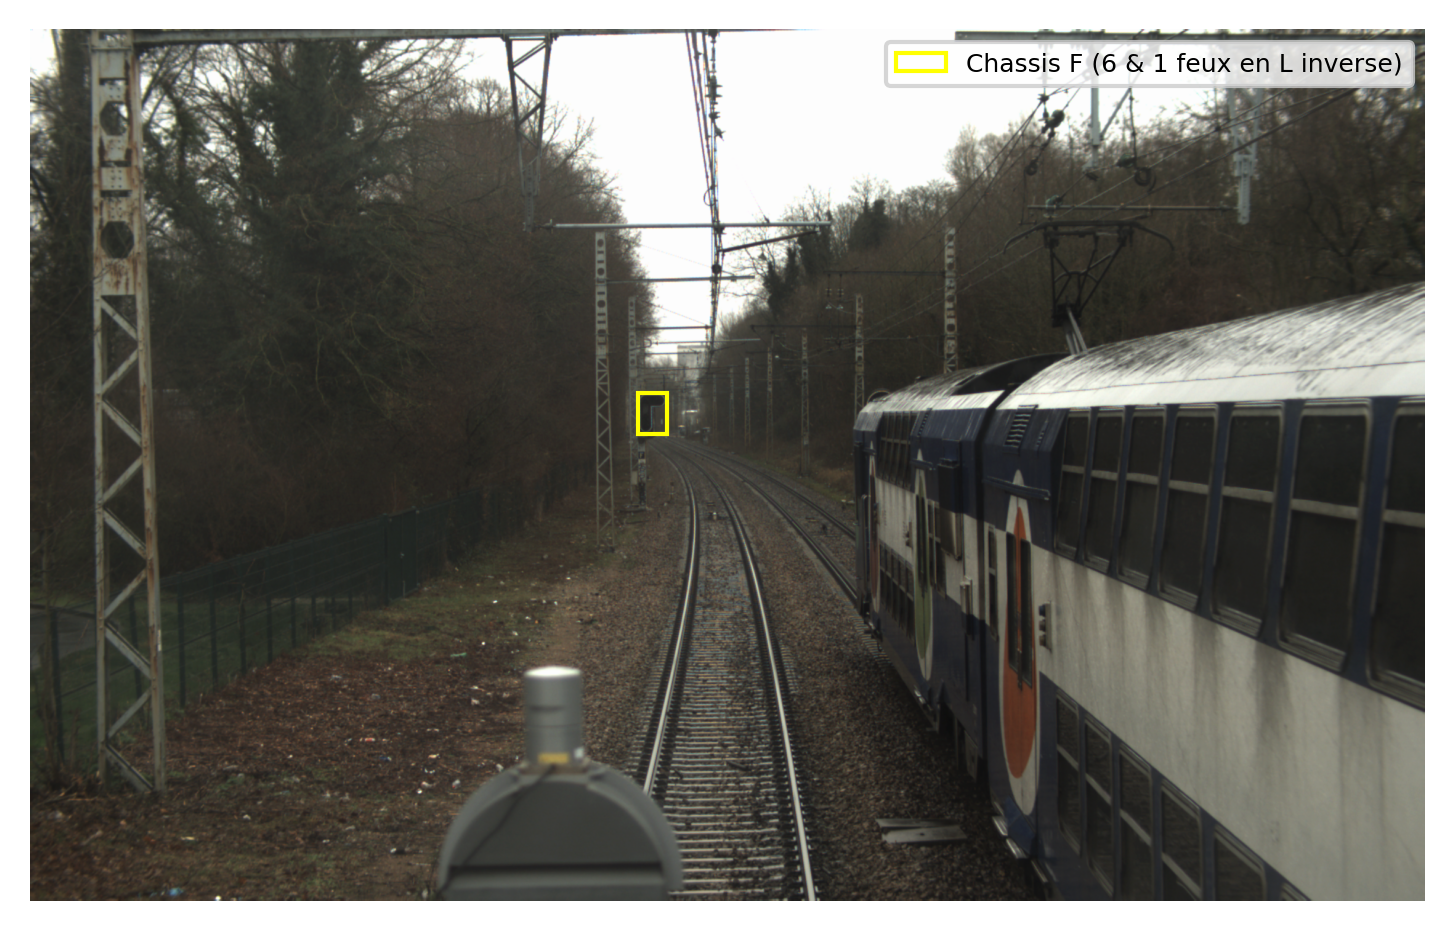

In [156]:
matplotlib.rcParams["figure.dpi"] = 300

sample_id = np.random.randint(0, len(img_objs), 1)[0]

img_obj = img_objs[sample_id]
pred_obj = predict_objs[sample_id]

img = np.asarray(Image.open(io.BytesIO(img_obj.get()["Body"].read())))
preds = json.loads(pred_obj.get()["Body"].read().decode("utf-8"))
sample_fig = plot_predictions_on_image(img, preds, 0.20, True)

In [54]:
preds

{'image_height': 1200,
 'image_width': 1920,
 'pred_boxes': [[456.20672607421875,
   58.648075103759766,
   614.951171875,
   314.3643493652344]],
 'scores': [0.9378290772438049],
 'pred_classes': [3]}

In [55]:
classes

['Chassis A (3 feux verticaux)',
 'Chassis C (5 feux verticaux)',
 'Chassis F (6 & 1 feux en L inverse)',
 'Chassis H (6 & 3 feux en S)',
 'Chassis ID2 (2 feux horizontaux)',
 'Chassis ID3 (3 feux horizontaux)',
 'Chassis R (6 feux dans un disque)']

### 6.3 Real-time inference with SageMaker Endpoint

We can also deploy a SageMaker Endpoint with our fine-tuned model, for performing detections in real-time for any image of our choice.

In [59]:
#Deploy endpoint
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

predictor = model.deploy(
    endpoint_name='d2-frsign-endpoint',
    initial_instance_count=1,
    instance_type='ml.g4dn.xlarge',
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer(),
)

Using already existing model: d2-frsign-model


-------------!

We will test with a sample image from a Spanish railway in Atocha station (Madrid).

Note our model has never seen this image before, as our fine tuning was done with the FRSign dataset from the French railways, but it can still detect the traffic lights on it.

In [96]:
filename='./renfe2.png' #Test image from Renfe Atocha

b = ""
with open(filename, "rb") as image:
    f = image.read()
    b = bytearray(f)

runtime = boto3.client(service_name="runtime.sagemaker")
endpoint_response = runtime.invoke_endpoint(EndpointName='d2-frsign-endpoint', ContentType="application/x-image", Body=b)
results = json.loads(endpoint_response["Body"].read())
results

{'image_height': 807,
 'image_width': 1303,
 'pred_boxes': [[765.7049560546875,
   282.5265808105469,
   783.2827758789062,
   310.66131591796875],
  [1222.87060546875, 275.201904296875, 1243.7049560546875, 318.84759521484375],
  [1222.642578125, 276.6622619628906, 1244.80712890625, 319.0503234863281]],
 'scores': [0.6277568340301514, 0.12416800856590271, 0.10484503954648972],
 'pred_classes': [0, 3, 2]}

### 6.3.1 Visualization

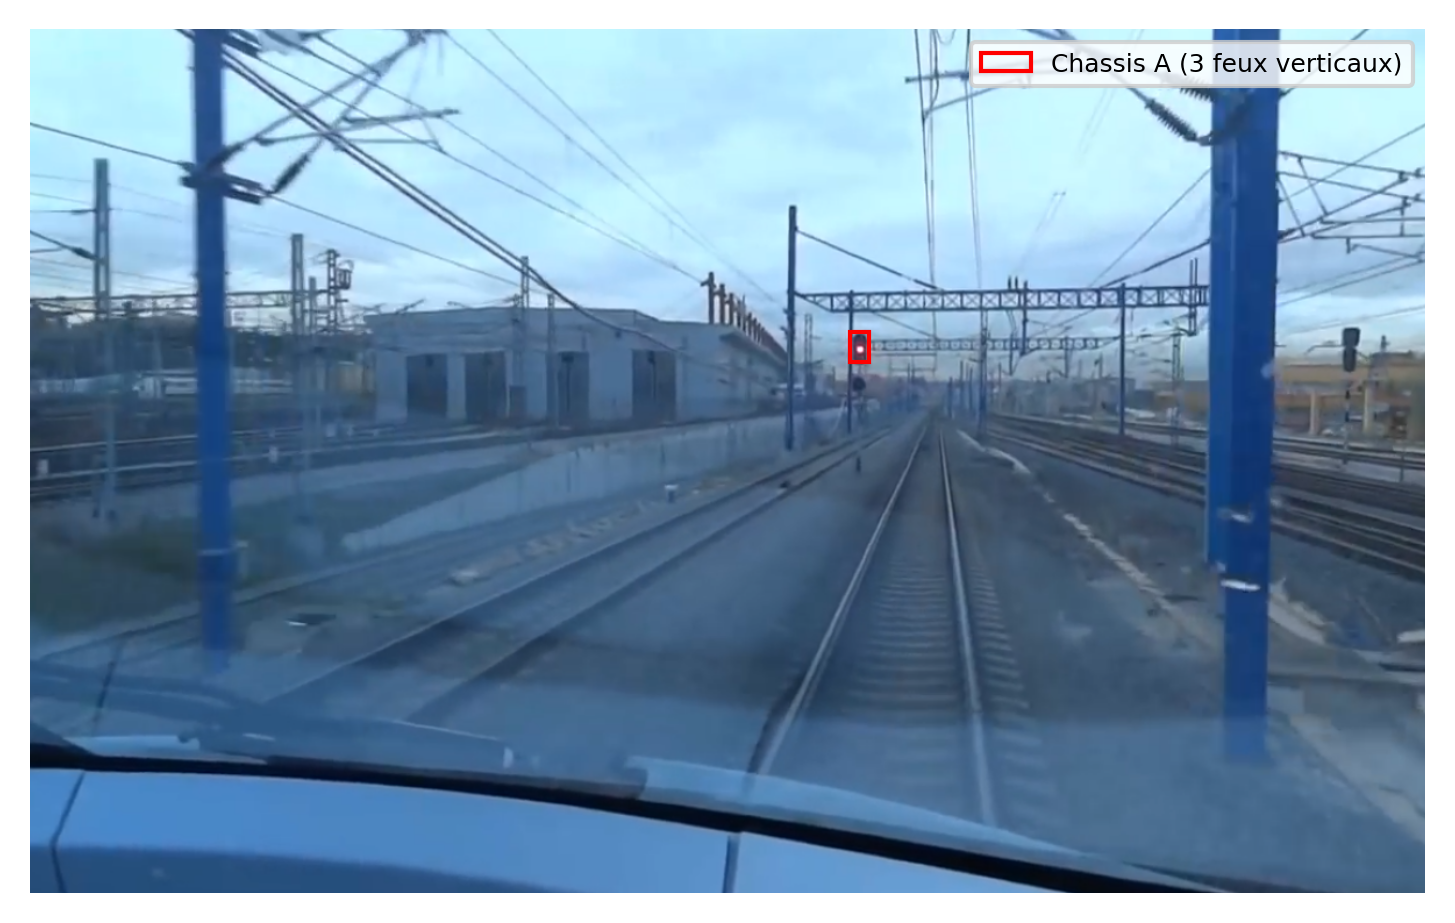

In [157]:
test_img = np.array(Image.open(filename))
test_fig = plot_predictions_on_image(test_img, results, 0.40, True)